In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier 

# Build and test a Nearest Neighbors classifier.

- We will try to build the best possible nearest neighbors classifier for a specific data set. By 'best', we mean _highest accuracy_
- Use a train/dev/test split
- Experiment with as many hyper-parameters as possible



### Load the Iris data

Load the Iris data to use for experiments. The data include 50 observations of each of 3 types of irises (150 total). Each observation includes 4 measurements: sepal and petal width and height. The goal is to predict the iris type from these measurements.

<http://en.wikipedia.org/wiki/Iris_flower_data_set>

In [3]:
# Load the data, which is included in sklearn.
iris = load_iris()
print 'Iris target names:', iris.target_names
print 'Iris feature names:', iris.feature_names
X, y = iris.data, iris.target

Iris target names: ['setosa' 'versicolor' 'virginica']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


### Take a quick look at the data

In [4]:
#Look at first five rows of feature matrix
X[:5]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2]])

In [5]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [6]:
X.shape


(150, 4)

150 examples with four features each

This data is fairly well behaved. For now, we are going to skip EDA and feature engineering---which would normally be essential steps

### Break off a test set

In [7]:
np.random.seed(0)

test_size = 50
test_idx = np.random.choice(X.shape[0], test_size, replace = False)
train_idx = np.setdiff1d(range(X.shape[0]), test_idx)

X_train, y_train = X[train_idx, :], y[train_idx]
X_test, y_test = X[test_idx, :], y[test_idx]


In [8]:
X_train.shape

(100, 4)

At this point, we set aside the test set. We should only touch the test set once!

### Split the training set into development train/test

In [9]:
np.random.seed(1)

test_size = 30
devtest_idx = np.random.choice(train_idx, test_size, replace = False)
devtrain_idx = np.setdiff1d(train_idx, devtest_idx)

X_devtrain, y_devtrain = X[devtrain_idx, :], y[devtrain_idx]
X_devtest, y_devtest = X[devtest_idx, :], y[devtest_idx]



In [10]:
X_devtrain[:5]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 5. ,  3.6,  1.4,  0.2],
       [ 5.4,  3.9,  1.7,  0.4],
       [ 4.6,  3.4,  1.4,  0.3]])

In [11]:
y_devtest[:5]

array([2, 2, 0, 2, 2])

## Implement K Nearest Neighbors

### Implement a distance function

Create a distance function that returns the distance between 2 observations.

In [12]:
def EuclideanDistance(v1, v2):
    sum = 0.0
    for index in range(len(v1)):
        sum += (v1[index] - v2[index]) ** 2
    return sum ** 0.5

Just for fun, let's compute all the pairwise distances in the training data and plot a histogram.

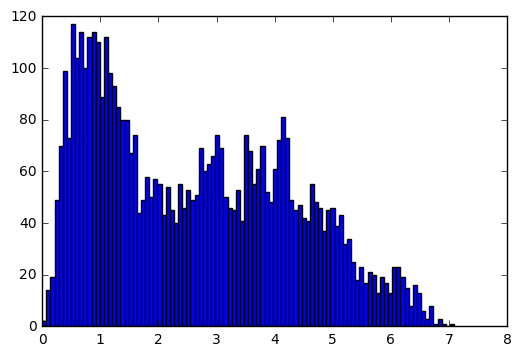

In [13]:
dists = []
for i in range(len(X_train) - 1):
    for j in range(i + 1, len(X_train)):
        dist = EuclideanDistance(X_train[i], X_train[j])
        dists.append(dist)
        
fig = plt.hist(dists, 100)

##### Pythonic (scienthonic?) versions of the above two cells

Python is great for data science because there are a ton of high-level, commonly used, and often vectorized operations.

Let's implement a vectorized version of the Euclidean Distance function.

In [14]:
from scipy.spatial.distance import pdist

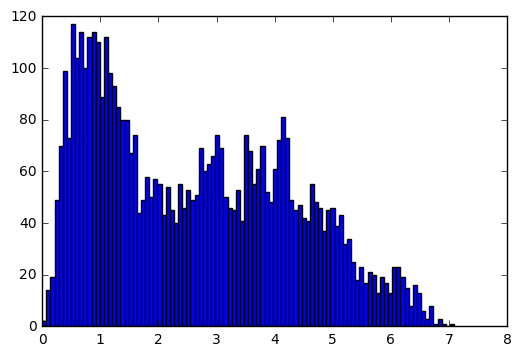

In [15]:
def EuclideanDistance(v1, v2):
    dist = np.sum((v1 - v2)**2)**.5
    return dist

dists = pdist(X_train, metric = EuclideanDistance)
fig = plt.hist(dists, 100)

### 1-NN Classifier

Ok now let's create a class that implements a Nearest Neighbors classifier. We'll model it after the sklearn classifier implementations, with fit() and predict() methods.

<http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier>

Test cdist function

In [23]:
from scipy.spatial.distance import cdist

#get one observation of training data features
test_item = X_train[5]
print test_item

#note need to put test_item within a list because when it is not in a list, we get an error:
#ValueError: XA must be a 2-dimensional array.
#So need to make test_item a 2-dimensional array. cdist wants to compare two lists of coordinates
test_dists = cdist([test_item], X_train, metric = EuclideanDistance)

np.argmin(test_dists)


[ 4.6  3.4  1.4  0.3]


5

In [27]:
#look to use the cdist function
from scipy.spatial.distance import cdist

#np.argmin

class NearestNeighbors(object):
    
    def __init__(self, metric = EuclideanDistance):
        self.metric = metric
        
    def fit(self, data, labels):
        self.train_data = data
        self.train_labels = labels
        
    def predict(self, test_data):
        results = []
        for item in test_data:
            results.append(self._predict_item(item))
            
        return results
            
    def _predict_item(self, item):
        """return label of training example nearest to item"""
        
        #cdist computes distance between each pair of two collections of inputs
        #get distance between item and all other items in the training data with cdist function
        distances = cdist([item], self.train_data, metric = self.metric)[0]
        min_index = np.argmin(distances)
        
        best_label = self.train_labels[min_index]
        
        return best_label
    

#### Test

See how well the classifier performs

In [33]:
clf = NearestNeighbors()
clf.fit(X_devtrain, y_devtrain)
preds = clf.predict(X_devtest)

print preds
print len(preds)

correct = np.sum(preds==y_devtest)
total = len(y_devtest)
print 'total: {}  correct: {}  accuracy: {:.3}'.format(total, correct, 1.0 * correct / total)

[2, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 2, 2, 1, 0, 1, 2, 0, 2, 1]
30
total: 30  correct: 29  accuracy: 0.967


### k nearest neighbors

The implementation above only allows for a single nearest neighbor; that is, the classifier predicts the label of the closest available point. What about using more than one nearest neighbor. Typically, this means to make a prediciton we:

1. Find the k closest points (according to our distance metric) to the query point.
2. Find the majority label of those k points found in (1)
3. Return the label in (2) as the prediction

Try implementing this strategy below.
Hint: Check out the `most_common` method in `Counter`

In [52]:
from collections import Counter

?Counter.most_common

In [58]:
test = [2,4,2,3,5,3,2,4,1,5,5,1,2,5,1,3]

c = Counter()
winner = Counter(test).most_common(1)
print winner[0][0]


#test2 = [test[i] for i in [1,4,7]]
#print test2



2


In [63]:
class k_NearestNeighbors(object):
    
    def __init__(self, metric = EuclideanDistance):
        self.metric = metric
        
    def fit(self, data, labels):
        self.train_data = data
        self.train_labels = labels
        
    def predict(self, test_data, k):
        self.k = k
        results = []
        for item in test_data:
            results.append(self._predict_item(item))
            
        return results
            
    def _predict_item(self, item):
        """return label of training example nearest to item"""
        
        #cdist computes distance between each pair of two collections of inputs
        #get distance between item and all other items in the training data with cdist function
        distances = cdist([item], self.train_data, metric = self.metric)[0]
        #get the indices of the k nearest neighbors
        nearest_neighbors = np.argsort(distances)[:self.k]
        
        #get the labels of the k nearest neighbors
        nn_label_votes = [self.train_labels[i] for i in nearest_neighbors]
        
        best_label = Counter(nn_label_votes).most_common(1)[0][0]
        
        return best_label

#### Test

`NearestNeighbors` and `OurKNearestNeighbors` should give the same prediction (when k=1)

In [66]:
clf = k_NearestNeighbors()
clf.fit(X_devtrain, y_devtrain)
preds = clf.predict(X_devtest, k = 4)

print preds
print len(preds)

correct = np.sum(preds==y_devtest)
total = len(y_devtest)
print 'total: {}  correct: {}  accuracy: {:.3}'.format(total, correct, 1.0 * correct / total)

[2, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 2, 2, 1, 0, 1, 2, 0, 1, 1]
30
total: 30  correct: 30  accuracy: 1.0


### Picking k: the number of neighbors to use in classification

Implement a way to pick the number of neighbors to use in the classifier. We already have a test set, so simply extend the procedure in the previous code cell to run over different numbers of neighbors. Plot the test set performance versus the number of neighbors.

(-0.1, 1.1)

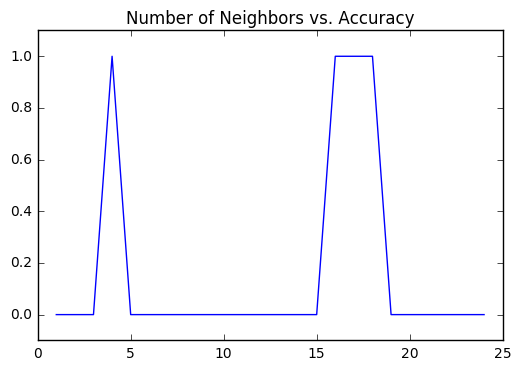

In [72]:
k_nn_perf = []

number_nn = range(1,25)

for neighbors in number_nn:
    clf = k_NearestNeighbors()
    clf.fit(X_devtrain, y_devtrain)
    preds = clf.predict(X_devtest, k = neighbors)
    correct = np.sum(preds==y_devtest)
    total = len(y_devtest)
    accuracy = correct/total
    
    k_nn_perf.append(accuracy)
    
#Plot accuracy vs. k
plt.plot(number_nn, k_nn_perf, label='Number of Neighbors vs. Accuracy')
plt.title('Number of Neighbors vs. Accuracy')
plt.ylim((-.1,1.1))


### This isn't really enough information. Let's try using more train/dev splits

Step 1 - Write a function that splits a training dataset randomly, builds a kNN classifier, and reports the acccuracy

In [117]:
iris = load_iris()
X, y = iris.data, iris.target

def full_knn_func(features, labels, test_size, dev_train_size, num_neighbors):

    #Split full data into test and train
    test_idx = np.random.choice(features.shape[0], test_size, replace = False)
    train_idx = np.setdiff1d(range(features.shape[0]), test_idx)

    X_train, y_train = features[train_idx, :], labels[train_idx]
    X_test, y_test = features[test_idx, :], labels[test_idx]
    
    #Split training into training and development
    devtest_idx = np.random.choice(train_idx, dev_train_size, replace = False)
    devtrain_idx = np.setdiff1d(train_idx, devtest_idx)

    X_devtrain, y_devtrain = features[devtrain_idx, :], labels[devtrain_idx]
    X_devtest, y_devtest = features[devtest_idx, :], labels[devtest_idx]

    #fit model
    model = k_NearestNeighbors()
    model.fit(X_devtrain, y_devtrain)
    preds = model.predict(X_devtest, k = num_neighbors)

    correct = np.sum(preds==y_devtest)
    total = len(y_devtest)
    accuracy = float(correct) / float(total)
    return accuracy


In [127]:
full_knn_func(features = X, labels = y, test_size = 50, dev_train_size = 30, num_neighbors = 2)


0.9333333333333333

Step 2 - Run the above function 500 times for each value of k between 1 and 15 to get the mean test accuracy for that value of k

In [135]:
repetitions = 500
number_nn = range(1,15)
mean_accuracy_list = []

for nn in number_nn:
    i = 0
    intermed_acc_list = []
    while i < repetitions:
        accuracy = full_knn_func(features = X, labels = y, test_size = 50, dev_train_size = 30, num_neighbors = nn)
        intermed_acc_list.append(accuracy)
        i += 1
    
    mean_acc = np.mean(intermed_acc_list)
    mean_accuracy_list.append(mean_acc)


(0.93, 0.97)

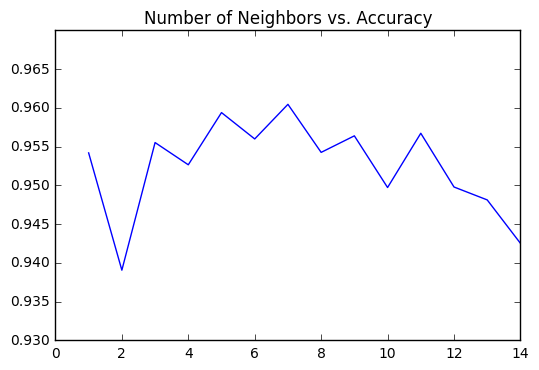

In [137]:
plt.plot(number_nn, mean_accuracy_list, label='Number of Neighbors vs. Accuracy')
plt.title('Number of Neighbors vs. Accuracy')
plt.ylim((0.93,0.97))



Step 3 (optional) - If you would like, now would be the time to experiment with different distance metrics. Repeat the above step and see what the results look like

### Deployment

Use Occam's razor to select the best model.

Once you have chosen the hyper-parameters for the model (k and distance metric), it is time to deploy the model. Now is the time to test our model on the test set, so that we know what to expect after deployment.

In [139]:
final_model = k_NearestNeighbors()
final_model.fit(X_devtrain, y_devtrain)
preds = final_model.predict(X_test, k = 5)

print preds
print len(preds)

correct = np.sum(preds==y_test)
total = len(y_test)
print 'total: {}  correct: {}  accuracy: {:.3}'.format(total, correct, 1.0 * correct / total)

[2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2]
50
total: 50  correct: 49  accuracy: 0.98


Note: Before deploying the model, we could actually incorporate the test data into our training set. The only thing that matters now, is how well the model generalizes in the real world.

### Visualizing the results

We've been a litte haphazard so far, we should have plotted the data and some results to get an idea of how the algorithm is performing. Plot the data with the true labels as colors, and plot it with some fitted labels, for differing values of k, to see how our KNN algorithm is performing.

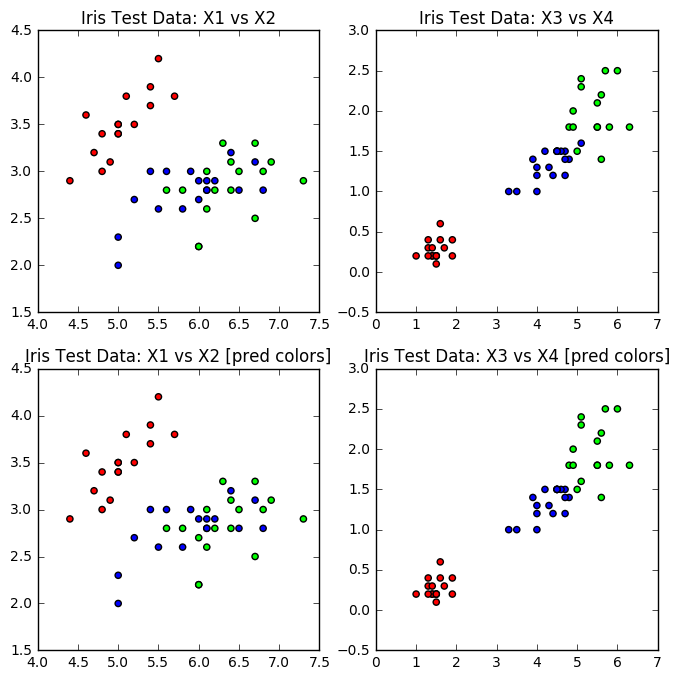

In [140]:
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])

plt.figure(figsize=(8,8)) 
p = plt.subplot(2, 2, 1)
p.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright)
plt.title("Iris Test Data: X1 vs X2")

p = plt.subplot(2, 2, 2)
p.scatter(X_test[:, 2], X_test[:, 3], c=y_test, cmap=cm_bright)
plt.title("Iris Test Data: X3 vs X4")

p = plt.subplot(2, 2, 3)
p.scatter(X_test[:, 0], X_test[:, 1], c=preds, cmap=cm_bright)
plt.title("Iris Test Data: X1 vs X2 [pred colors]")

p = plt.subplot(2, 2, 4)
p.scatter(X_test[:, 2], X_test[:, 3], c=preds, cmap=cm_bright)
plt.title("Iris Test Data: X3 vs X4 [pred colors]")

## Bonus: Implement variable scaling. 

That is, scale each feature to its normalized z-score. Make sure not to contaminate the test set..

Repeat steps one and two above

Step 1

In [155]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

?Pipeline

In [152]:
scale = StandardScaler()

test = scale.fit_transform(X_devtrain)
#note documentation had a note about Pipeline compatibility: y: Passthrough for ``Pipeline`` compatibility. :

?StandardScaler




In [154]:
scale = StandardScaler()
pipeline = Pipeline([('first_scale',StandardScaler), ("fit_knn_model", k_NearestNeighbors)])


Step 2

Question: Did variable scaling improve anything? Why or why not?